In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import admix
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import string
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
from scipy.stats import combine_pvalues

In [2]:
def meta_analysis(effects, se, method="random", weights=None):
    # From Omer Weissbrod
    assert method in ["fixed", "random"]
    d = effects
    variances = se ** 2

    # compute random-effects variance tau2
    vwts = 1.0 / variances
    fixedsumm = vwts.dot(d) / vwts.sum()
    Q = np.sum(((d - fixedsumm) ** 2) / variances)
    df = len(d) - 1
    tau2 = np.maximum(0, (Q - df) / (vwts.sum() - vwts.dot(vwts) / vwts.sum()))

    # defing weights
    if weights is None:
        if method == "fixed":
            wt = 1.0 / variances
        else:
            wt = 1.0 / (variances + tau2)
    else:
        wt = weights

    # compute summtest
    summ = wt.dot(d) / wt.sum()
    if method == "fixed":
        varsum = np.sum(wt * wt * variances) / (np.sum(wt) ** 2)
    else:
        varsum = np.sum(wt * wt * (variances + tau2)) / (np.sum(wt) ** 2)
    ###summtest = summ / np.sqrt(varsum)

    summary = summ
    se_summary = np.sqrt(varsum)

    return summary, se_summary

In [3]:
SUPP_TABLE_URL = "supp_tables.xlsx"
trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name="trait-info")
trait_list = trait_info["trait"].values
dict_trait_display_name = {
    row["trait"]: row["display-name"] for _, row in trait_info.iterrows()
}
dict_trait_display_name["a1c"] = r"HbA$_{1c}$"

dict_trait_category = {row.trait: row.category for _, row in trait_info.iterrows()}

In [4]:
def estimate_rg(est, est_var):
    """
    Estimate the ratio of genetic correlation.
    est: (3, ) numpy array
    est_var (3, 3) variance-covariance matrix
    """
    x, y = est[0], est[1]
    rg = y / x
    # grad = [-y / x^2, 1 / x]
    grad = np.array([-y / (x ** 2), 1 / x])

    def quad_form(x, A):
        return np.dot(np.dot(x.T, A), x)

    return rg, quad_form(grad, est_var[0:2, 0:2])

In [8]:
df_plot = {
    "trait": [],
    "n_indiv": [],
    "rg": [],
    "rg_stderr": [],
    "snpset": [],
    "hermodel": [],
}

for trait in trait_list:
    for snpset in ["imputed"]:
        for hermodel in ["mafukb", "gcta"]:
            reml_file = f"out/gcta-estimate-jan-27/{trait}.{snpset}.{hermodel}"
            if trait == "total_wbc_cnt":
                reml_file += ".duffy_covar"
            reml_rls = admix.tools.gcta.read_reml(reml_file)
            n_indiv = reml_rls["n"]
            gcta_rg, gcta_rg_var = estimate_rg(
                reml_rls["est"]["Variance"].values, reml_rls["varcov"].values
            )
            gcta_rg_stderr = np.sqrt(gcta_rg_var)
            # fill in data for plotting
            df_plot["trait"].append(trait)
            df_plot["snpset"].append(snpset)
            df_plot["hermodel"].append(hermodel)
            df_plot["n_indiv"].append(n_indiv)

            # REML
            df_plot["rg"].append(gcta_rg)
            df_plot["rg_stderr"].append(gcta_rg_stderr)

df_plot = pd.DataFrame(df_plot)
df_plot["pval"] = stats.norm.cdf((df_plot["rg"] - 1) / df_plot["rg_stderr"])
df_plot["category"] = [dict_trait_category[trait] for trait in df_plot["trait"]]
df_plot["category"] = df_plot["category"].astype("category")

In [14]:
df_plot

,trait,n_indiv,rg,rg_stderr,snpset,hermodel,pval,category
0,crp,8521,0.982904,0.058794,imputed,mafukb,0.385608,inflammatory
1,crp,8521,0.993169,0.050401,imputed,gcta,0.446094,inflammatory
2,total_wbc_cnt,8889,0.930436,0.076733,imputed,mafukb,0.182317,inflammatory
3,total_wbc_cnt,8889,0.940520,0.068273,imputed,gcta,0.191821,inflammatory
4,mean_corp_hgb_conc,3816,0.885964,0.195627,imputed,mafukb,0.279971,inflammatory
5,mean_corp_hgb_conc,3816,0.950120,0.130718,imputed,gcta,0.351384,inflammatory
6,platelet_cnt,8871,0.883233,0.108748,imputed,mafukb,0.141470,inflammatory
7,platelet_cnt,8871,0.892714,0.101108,imputed,gcta,0.144321,inflammatory
8,hdl,10248,0.909401,0.092519,imputed,mafukb,0.163730,lipid
9,hdl,10248,0.922395,0.080796,imputed,gcta,0.168400,lipid


In [12]:
meta_analysis(df_plot["rg"], df_plot["rg_stderr"])

(0.9689764360438434, 0.011785327645629033)

In [13]:
meta_analysis(df_plot_new["rg"], df_plot_new["rg_stderr"])

(0.9677027993364267, 0.011667327741574753)

In [7]:
df_plot_new = df_plot.copy()

# Bar plots of the estimates

<ipython-input-6-3c66f1c328e2>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
<ipython-input-6-3c66f1c328e2>:42: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


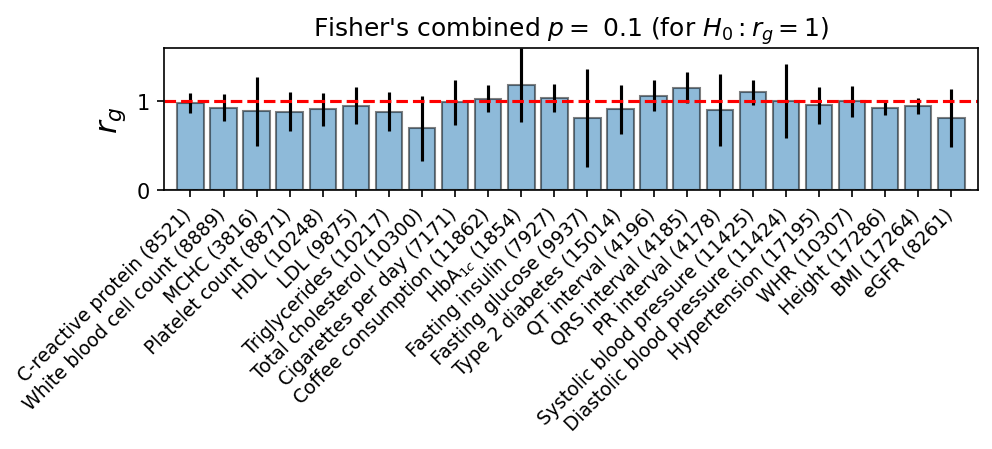

In [6]:
df_tmp = df_plot[(df_plot.snpset == "imputed") & (df_plot.hermodel == "mafukb")]

fig, ax = plt.subplots(figsize=(7, 1.25), dpi=150)

ax.bar(
    df_tmp["trait"],
    df_tmp["rg"],
    yerr=df_tmp["rg_stderr"] * 2,
    align="center",
    alpha=0.5,
    ecolor="black",
    edgecolor="black",
    capsize=0,
)

display_name = [
    f"{dict_trait_display_name[row.trait]} ({row.n_indiv})"
    for _, row in df_tmp.drop_duplicates(subset=["trait"]).iterrows()
]
ax.set_xticklabels(
    display_name,
    rotation=45,
    va="top",
    ha="right",
    fontsize=9,
)

ax.axhline(y=1.0, ls="--", color="r")
ax.axhline(y=0.0, ls="--", color="gray")
trans = mtrans.Affine2D().translate(5, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform() + trans)

ax.set_ylabel("$r_g$", fontsize=15)
ax.set_title(
    f"Fisher's combined $p=${combine_pvalues(df_tmp.pval)[1]: .1g} (for $H_0: r_g = 1$)"
)
fig.show()

ax.set_ylim(0, 1.6)
ax.set_xlim(-0.8, 23.8)
plt.tight_layout()
# plt.savefig("results/genome-wide.pdf", bbox_inches="tight")

In [8]:
df_tbl = df_plot[(df_plot.snpset == "imputed") & (df_plot.hermodel == "mafukb")].drop(
    columns=["snpset", "hermodel", "category"]
)
df_tbl.to_csv("results/admix-corr.csv", index=False)
# meta-analysis results
meta_mean, meta_se = meta_analysis(df_tbl["rg"], df_tbl["rg_stderr"])

df_tbl = df_tbl.append(
    {
        "trait": "Meta-analysis",
        "n_indiv": 0,
        "rg": meta_mean,
        "rg_stderr": meta_se,
        "pval": stats.norm.cdf((meta_mean - 1) / meta_se),
    },
    ignore_index=True,
)

df_tbl["trait"] = df_tbl["trait"].apply(
    lambda x: dict_trait_display_name[x] if x in dict_trait_display_name else x
)
df_tbl["n_indiv"] = df_tbl["n_indiv"].astype(int)
df_tbl["rg"] = df_tbl["rg"].apply(lambda x: f"{x:.3f}")
df_tbl["rg_stderr"] = df_tbl["rg_stderr"].apply(lambda x: f"{x:.3f}")
df_tbl["pval"] = df_tbl["pval"].apply(lambda x: f"{x:.3f}")

df_tbl = df_tbl.rename(
    columns={
        "trait": "Phenotype",
        "n_indiv": "$N$",
        "rg": "$\widehat{r_g}$",
        "rg_stderr": "$\widehat{\text{s.e.}(r_g)}$",
        "pval": "$p$-value",
    }
)

In [11]:
print(df_tbl.to_latex(escape=False, index=False))

\begin{tabular}{lrlll}
\toprule
               Phenotype &   $N$ & $\widehat{r_g}$ & $\widehat{\text{s.e.}(r_g)}$ & $p$-value \\
\midrule
      C-reactive protein &  8521 &           0.983 &                        0.059 &     0.386 \\
  White blood cell count &  8889 &           0.930 &                        0.077 &     0.182 \\
                    MCHC &  3816 &           0.886 &                        0.196 &     0.280 \\
          Platelet count &  8871 &           0.883 &                        0.109 &     0.141 \\
                     HDL & 10248 &           0.909 &                        0.093 &     0.164 \\
                     LDL &  9875 &           0.951 &                        0.104 &     0.319 \\
           Triglycerides & 10217 &           0.882 &                        0.110 &     0.141 \\
       Total cholesterol & 10300 &           0.697 &                        0.183 &     0.048 \\
      Cigarettes per day &  7171 &           0.990 &                        0.126 &   

# Consistency of estimate with different assumed genetic architecture

In [17]:
df_tbl1 = df_plot[(df_plot.snpset == "imputed") & (df_plot.hermodel == "mafukb")].drop(
    columns=["snpset", "hermodel", "category"]
)
df_tbl2 = df_plot[(df_plot.snpset == "imputed") & (df_plot.hermodel == "gcta")].drop(
    columns=["snpset", "hermodel", "category"]
)

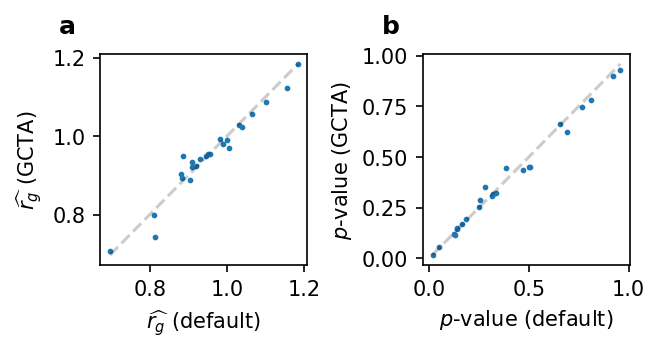

In [55]:
fig, axes = plt.subplots(figsize=(4.5, 2.5), dpi=150, ncols=2)

for i, (k, label) in enumerate(zip(["rg", "pval"], ["$\widehat{r_g}$", "$p$-value"])):
    axes[i].scatter(df_tbl1[k], df_tbl2[k], s=3)
    axes[i].set_xlabel(f"{label} (default)")
    axes[i].set_ylabel(f"{label} (GCTA)")

    lim = [
        min(df_tbl1[k].min(), df_tbl2[k].min()),
        max(df_tbl1[k].max(), df_tbl2[k].max()),
    ]

    # annotation
    axes[i].text(
        -0.2,
        1.1,
        string.ascii_lowercase[i],
        transform=axes[i].transAxes,
        size=12,
        weight="bold",
    )
    axes[i].plot([lim[0], lim[1]], [lim[0], lim[1]], "k--", alpha=0.2)

fig.tight_layout()
plt.savefig("results/real-genome-wide-assumption-robust.pdf", bbox_inches="tight")